# Introduction to forward-modelling: TRF
The Temporal Response Function is a generalization of ERP to continuous stimuli/signals. In summary, it is a linear spatio-temporal filter that allows to map one stimuli over electrophysiological data. Alternatively, it can be described as an impulse function, considering the brain (or at least the potential generating process) as a linear time invariant system for the considered stimuli. This model is described as "forward" because we map a stimuli onto neural data, thus following a causal direction. Obviously, this notion could be generalized to other processes where the causal relationship is not as clear, but for simplicity sake, we will only describe the example of sensory processing.

The main advantages of the TRF are that it is multivariate: it can take into account multiple regressor/stimuli and combine them, as well as multiple timelags, it is fast (at least as computed in this package) and it is linear and, therefore, easily explainable. This also implies that it cannot capture non-linearity by itself, but this is mitigated by the ability to use non-linear regressors.



## Importing the library

First, we install the necessary libraries. The spyeeg library contains utility functions that may be useful but most functions relevant to neuroscientists are located in "models", so let's import this one!

In [1]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale

## Let's Generate a simple example

To make things simpler, we will create a set of data to vizualize what the TRF package does easily

(0.0, 10.0)

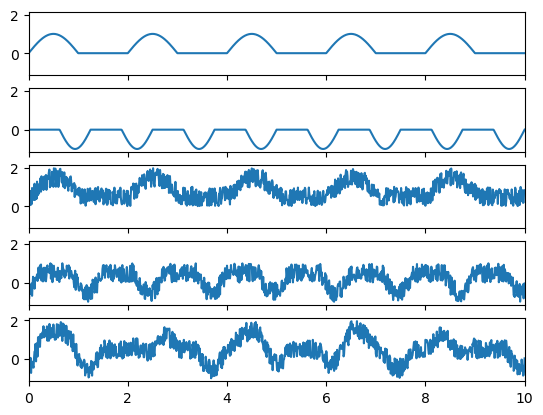

In [35]:
fs = 100
f_stim1 = 0.5
f_stim2 = 0.8
T = 600
time_array = np.linspace(0,T,int(T*fs))
stimuli_pos = np.clip(np.sin(2*np.pi*f_stim1*time_array),0,1)[:,np.newaxis]
stimuli_neg = np.clip(np.sin(2*np.pi*f_stim2*time_array),-1,0)[:,np.newaxis]
onsets_pos = signal.find_peaks(stimuli_pos[:,0])
onsets_neg = signal.find_peaks(stimuli_neg[:,0])
electrophysiological_data = np.hstack([np.roll(stimuli_pos,5) + np.random.random(stimuli_pos.shape) * 1, 
                                        np.roll(stimuli_neg,150) + np.random.random(stimuli_pos.shape) * 1, 
                                        np.roll(stimuli_pos,5) + np.roll(stimuli_neg,150) + np.random.random(stimuli_pos.shape) * 1])

fig, ax = plt.subplots(5, sharex = True, sharey=True)
ax[0].plot(time_array, stimuli_pos)
ax[1].plot(time_array, stimuli_neg)
ax[2].plot(time_array,electrophysiological_data[:,0])
ax[3].plot(time_array,electrophysiological_data[:,1])
ax[4].plot(time_array,electrophysiological_data[:,2])
ax[0].set_xlim([0,10])

## Simple fit

In [23]:
tmin = -1
tmax = 1
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0])

In [24]:
X = stimuli_pos
Y = electrophysiological_data

trf.fit(X, Y)

TRFEstimator(
            alpha=[0],
            fit_intercept=False,
            srate=100,
            tmin=-1,
            tmax=1,
            n_feats=1,
            n_chans=3,
            n_lags=200,
            features : None
        )
        

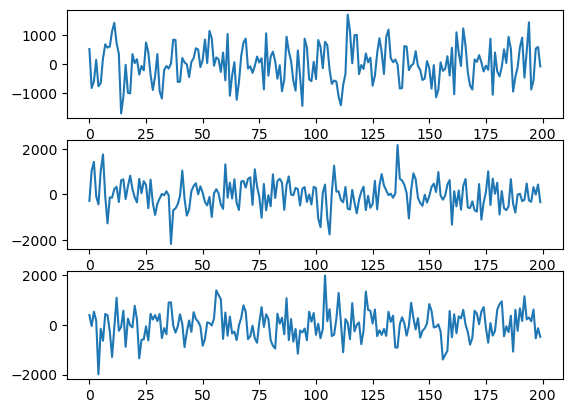

In [25]:
coefficients = trf.get_coef()
fig, ax = plt.subplots(coefficients.shape[2])
for i in range(coefficients.shape[2]):
    ax[i].plot(coefficients[:,0,i,0])

## Effect of Regularization

In [26]:
tmin = -1
tmax = 1
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))

In [27]:
X = stimuli_pos
Y = electrophysiological_data

scores = trf.xval_eval(X, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


Notice: kernels can have higher values because noise adds power. Make a comparison between white and pink noise. Make two different signals for input and compare decoding...etc
Note about R2 and corr: R2 does not mean anything

(0.0, 1.0)

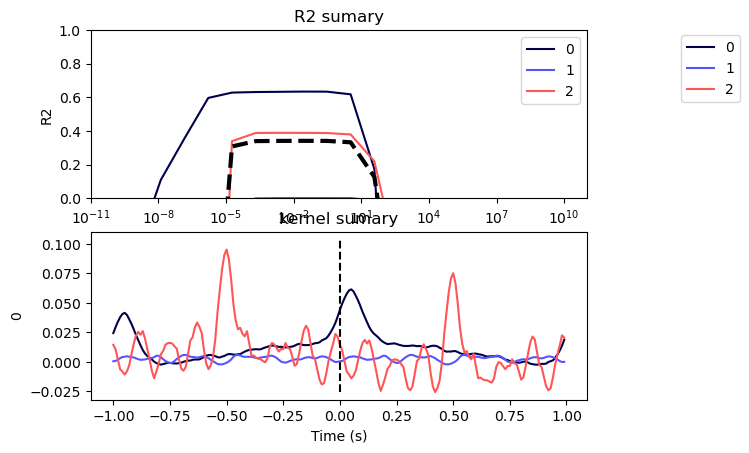

In [28]:
fig, ax = plt.subplots(2)

trf.plot_score(figax = (fig, ax[0]),minR2 = 0, color_type = 'seismic')
trf.plot_kernel(figax = (fig, ax[1]),minR2 = 0, color_type = 'seismic')
ax[0].set_ylim(0,1)

## Effect of scaling

In [29]:
tmin = -1
tmax = 1
trf1 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))
trf2 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))

In [30]:
X1 = scale(stimuli_pos)
X2 = scale(stimuli_neg)
Y = scale(electrophysiological_data)

scores1 = trf1.xval_eval(X1, Y, scoring = 'R2')
scores2 = trf2.xval_eval(X2, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


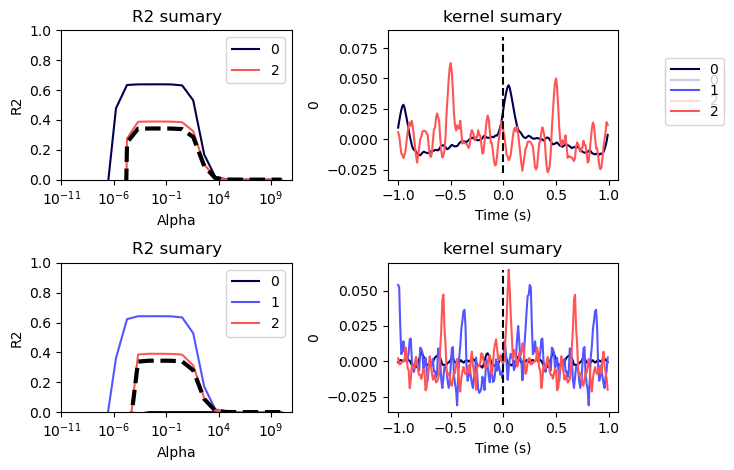

In [31]:
fig, ax = plt.subplots(2,2)

trf1.plot_score(figax = (fig, ax[0,0]),minR2 = 0, color_type = 'seismic')
trf1.plot_kernel(figax = (fig, ax[0,1]),minR2 = 0, color_type = 'seismic')
ax[0,0].set_ylim(0,1)

trf2.plot_score(figax = (fig, ax[1,0]),minR2 = 0, color_type = 'seismic')
trf2.plot_kernel(figax = (fig, ax[1,1]),minR2 = 0, color_type = 'seismic')
ax[1,0].set_ylim(0,1)

fig.tight_layout()

## Multivariate Analysis

In [36]:
tmin = -1
tmax = 1
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))

In [37]:
X = scale(np.hstack([stimuli_pos, stimuli_neg]))
Y = scale(electrophysiological_data)

scores = trf.xval_eval(X, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


(0.0, 1.0)

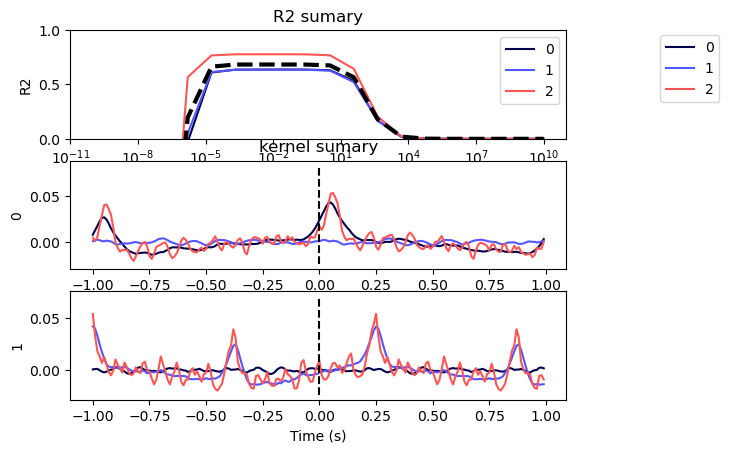

In [38]:
fig, ax = plt.subplots(3)

trf.plot_score(figax = (fig, ax[0]),minR2 = 0, color_type = 'seismic')
trf.plot_kernel(figax = (fig, ax[1:]),minR2 = 0, color_type = 'seismic')
ax[0].set_ylim(0,1)

## Sparse Stimuli

## Pink Noise

(0.0, 10.0)

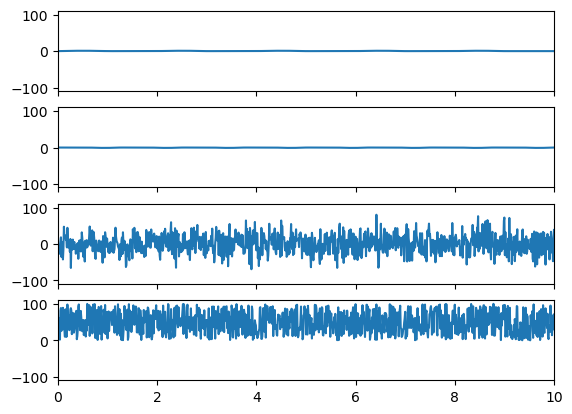

In [39]:
import colorednoise as cn

beta = 0.1 # the exponent

electrophysiological_data = np.hstack([np.roll(stimuli_pos,5) + cn.powerlaw_psd_gaussian(beta, stimuli_pos.shape[0])[:,np.newaxis]*25, 
                                        np.roll(stimuli_pos,5) + np.random.random(stimuli_pos.shape[0])[:,np.newaxis] * 100])
fig, ax = plt.subplots(4, sharex = True, sharey=True)
ax[0].plot(time_array, stimuli_pos)
ax[1].plot(time_array, stimuli_neg)
ax[2].plot(time_array,electrophysiological_data[:,0])
ax[3].plot(time_array,electrophysiological_data[:,1])
ax[0].set_xlim([0,10])

In [40]:
tmin = -1
tmax = 1
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))

In [41]:
X = scale(np.hstack([stimuli_pos, stimuli_neg]))
Y = scale(electrophysiological_data)

scores = trf.xval_eval(X, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


(0.0, 0.0003)

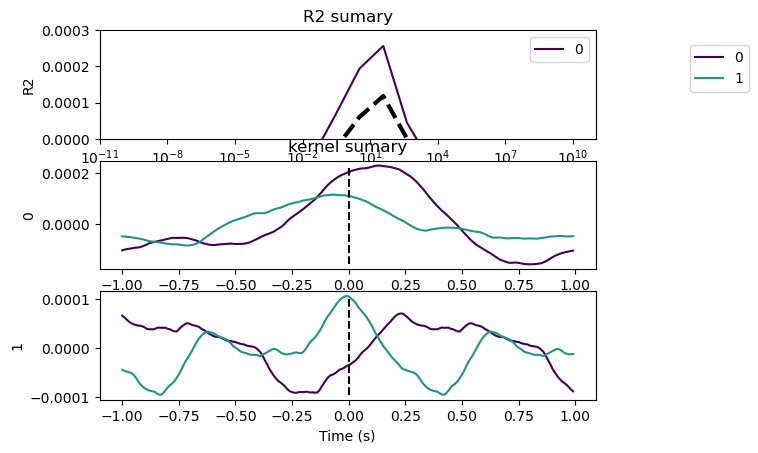

In [43]:
fig, ax = plt.subplots(3)

trf.plot_score(figax = (fig, ax[0]),minR2 = 0, color_type = 'viridis')
trf.plot_kernel(figax = (fig, ax[1:]), color_type = 'viridis')
ax[0].set_ylim(0,0.0003)

In [19]:
Y.shape

(60000, 4)